**Integración de Embeddings**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Se cambia el directorio donde se encuentra el archivo .csv
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

# Se Cargan los datos del archivo CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_alianzas_agrosavia.csv')

In [6]:
!pip install gensim

In [9]:
!pip install numpy --upgrade --force-reinstall
!pip install gensim --upgrade --force-reinstall

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
# Se cargan datos
df = df.dropna(subset=['ali_id', 'uniorg_id'])
df['ali_id'] = df['ali_id'].astype(str)
df['uniorg_id'] = df['uniorg_id'].astype(str)

# EMBEDDING 1: FACTORIZACIÓN MATRICIAL (SVD)
bipartita = pd.crosstab(df['ali_id'], df['uniorg_id'])

svd = TruncatedSVD(n_components=10, random_state=42)
embedding_svd = svd.fit_transform(bipartita.T)  # T para instituciones como filas
df_svd = pd.DataFrame(embedding_svd, index=bipartita.columns)
df_svd.columns = [f"svd_{i+1}" for i in df_svd.columns]

# EMBEDDING 2: WORD2VEC DE INSTITUCIONES EN PROYECTOS

corpus = df.groupby('ali_id')['uniorg_id'].apply(list).tolist()
model_w2v = Word2Vec(sentences=corpus, vector_size=10, window=5, min_count=1, sg=1, seed=42)
embedding_w2v = {inst: model_w2v.wv[inst] for inst in model_w2v.wv.index_to_key}
df_w2v = pd.DataFrame.from_dict(embedding_w2v, orient='index')
df_w2v.columns = [f"w2v_{i+1}" for i in df_w2v.columns]

# Se unifican EMBEDDINGS

df_embeddings = df_svd.join(df_w2v, how='outer')

# Se muestran los primeros resultados
df_embeddings.head()

,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10
10,-6.325206e-09,6.850418e-03,6.272090e-02,-6.573321e-03,1.470632e-02,2.815523e-02,-5.875590e-02,7.243577e-02,7.248757e-04,3.703623e-03,0.088061,0.051378,0.073775,-0.021326,0.099918,-0.040805,-0.050839,-0.122718,-0.095189,-0.090327
1007,1.327066e-17,-5.614040e-17,-7.981373e-15,7.890893e-14,4.269047e-13,-1.973306e-14,-1.975159e-13,2.648202e-13,-1.350766e-12,4.699888e-12,-0.086862,-0.088975,-0.004194,-0.093143,-0.031819,0.013722,-0.018969,-0.059344,-0.043058,0.020861
1012,-4.924685e-14,-5.086858e-13,-9.982043e-11,2.015261e-10,2.472937e-09,-2.579276e-09,7.424633e-09,-3.221795e-09,4.554788e-09,2.498231e-08,0.083567,0.060611,0.096512,-0.017202,-0.074257,-0.000236,0.047559,0.051296,-0.023615,-0.042854
1013,-1.422363e-17,3.491334e-17,3.023946e-14,-6.491874e-13,-1.613084e-12,4.194496e-12,-5.412754e-12,1.244957e-12,2.917073e-12,4.791728e-12,0.044590,-0.074923,-0.039728,-0.017615,-0.063759,0.070330,0.088117,-0.051023,-0.096691,-0.046606
1019,-1.003454e-11,3.661375e-03,8.029764e-03,2.473594e-02,4.023613e-02,1.645277e-01,2.886470e-02,-7.440162e-02,-7.892230e-04,1.985166e-01,0.034935,-0.020621,-0.102662,0.017097,0.066111,-0.086801,-0.092634,-0.031305,-0.002099,-0.011126


In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_embeddings(df_emb, metodo='tsne', etiquetas=None, random_state=42):
    if metodo == 'tsne':
        red = TSNE(n_components=2, perplexity=30, random_state=random_state)
    elif metodo == 'pca':
        red = PCA(n_components=2)
    else:
        raise ValueError("Método debe ser 'tsne' o 'pca'")

    emb_2d = red.fit_transform(df_emb)
    df_plot = pd.DataFrame(emb_2d, columns=['x', 'y'])
    df_plot['institucion'] = df_emb.index if etiquetas is None else etiquetas

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_plot, x='x', y='y', s=50, hue='institucion', legend=False)
    for i, row in df_plot.iterrows():
        plt.text(row['x'], row['y'], row['institucion'], fontsize=9)
    plt.title(f"Visualización de Embeddings ({metodo.upper()})")
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

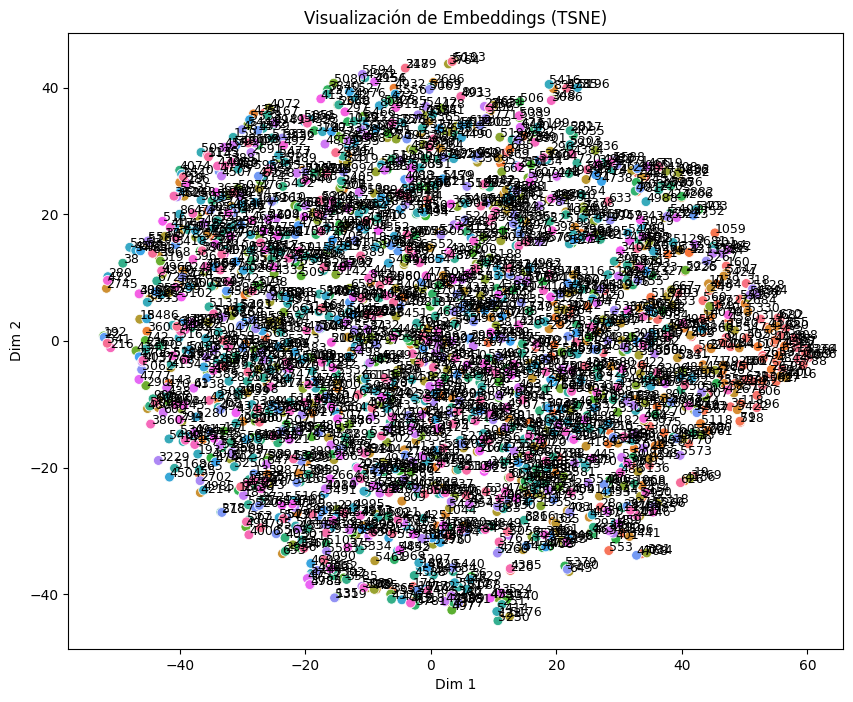

In [ ]:
visualizar_embeddings(df_w2v, metodo='tsne')

In [5]:
# Se instalan librerias Librerías
!pip install pyvis
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

df_info = df[['uniorg_id', 'uniorg_nombre', 'pais_desc', 'tipuniorg_desc']].drop_duplicates().set_index('uniorg_id')

# Se crea la función de recomendar por embeddings
def recomendar_por_embeddings(df_embeddings, institucion_base, top_k=10):
    if institucion_base not in df_embeddings.index:
        raise ValueError("La institución seleccionada no tiene embedding.")

    emb_base = df_embeddings.loc[institucion_base].values.reshape(1, -1)
    sim = cosine_similarity(df_embeddings, emb_base).flatten()
    sim_series = pd.Series(sim, index=df_embeddings.index)
    sim_series = sim_series.drop(institucion_base)

    recomendados = sim_series.sort_values(ascending=False).head(top_k).reset_index()
    recomendados.columns = ['institucion', 'similitud_coseno']
    return recomendados

def visualizar_subgrafo_pyvis(instituciones, df_info, titulo="Red de Recomendaciones"):
    net = Network(height="600px", width="100%", notebook=True,cdn_resources='in_line')
    net.force_atlas_2based()

    for inst in instituciones:
        nombre = df_info.loc[inst, 'uniorg_nombre']
        net.add_node(inst, label=nombre, shape='dot', size=15)

    for i in range(len(instituciones)):
        for j in range(i+1, len(instituciones)):
            net.add_edge(instituciones[i], instituciones[j])

    net.show_buttons(filter_=['physics'])
    return net.show("recomendaciones_pyvis.html")


# Se configura Widgets

# 1. Seleccionar tipo de embedding
selector_embedding = widgets.Dropdown(
    options=[
        ('Factorización SVD', 'svd'),
        ('Co-ocurrencia Word2Vec', 'w2v')
    ],
    description='Tipo de Embedding:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# 2. Seleccionar institución base (por nombre)
selector_institucion = widgets.Dropdown(
    options=[],  # Se llena dinámicamente
    description='Institución Base:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# 3. Slider para Top K
slider_topk = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Top K:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# 4. Botón recomendar
boton_recomendar = widgets.Button(description='Recomendar y Visualizar', button_style='success')

# 5. Área de salida
salida = widgets.Output()

# Mapeo nombre → ID
nombre_to_id = df_info['uniorg_nombre'].to_dict()
id_to_nombre = {v: k for k, v in nombre_to_id.items()}

# Se crea función de interacción

def on_change_embedding(change):
    if change['type'] == 'change' and change['name'] == 'value':
        tipo = change['new']
        if tipo == 'svd':
            instituciones_disp = df_svd.index.tolist()
        elif tipo == 'w2v':
            instituciones_disp = df_w2v.index.tolist()

        else:
            instituciones_disp = []

        # Llenar selector con nombres visibles
        opciones = [(df_info.loc[i, 'uniorg_nombre'], i) for i in instituciones_disp if i in df_info.index]
        selector_institucion.options = opciones

def on_click_recomendar(b):
    with salida:
        clear_output()
        tipo_emb = selector_embedding.value
        inst_base_id = selector_institucion.value
        top_k = slider_topk.value

        if tipo_emb == 'svd':
            df_emb = df_svd
        elif tipo_emb == 'w2v':
            df_emb = df_w2v

        else:
            df_emb = None

        if df_emb is not None:
            try:
                resultado = recomendar_por_embeddings(df_emb, inst_base_id, top_k=top_k)

                # Se muestran resultados
                resultado['nombre'] = resultado['institucion'].map(df_info['uniorg_nombre'].to_dict())
                display(resultado[['nombre', 'institucion', 'similitud_coseno']])

                # Se visualiza el subgrafo
                visualizar_subgrafo_pyvis([inst_base_id] + resultado['institucion'].tolist(), df_info)
                display(HTML("recomendaciones_pyvis.html"))

            except Exception as e:
                print(f"Error: {e}")

# Se enlazan eventos
selector_embedding.observe(on_change_embedding)
boton_recomendar.on_click(on_click_recomendar)

# Se muestra la interfaz
display(widgets.VBox([
    selector_embedding,
    selector_institucion,
    slider_topk,
    boton_recomendar,
    salida
]))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
